In [1]:
import numpy as np 
import pandas as pd 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

X_train_full = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
X_test = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv')

#Remove rows with missing target, separate target from predictors
X_train_full.dropna(axis=0, subset=['label'], inplace=True)
y_train_full = X_train_full.label
X_train_full.drop(['label'], axis=1, inplace=True)
y_test = X_test.label
X_test.drop(['label'], axis=1, inplace=True)

In [2]:
X_train_full

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X_train_full.shape

(60000, 784)

There are 42000 images, and each image has 784 features. This is because each image is 28 x 28 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). Let's take a look at one image from the dataset:

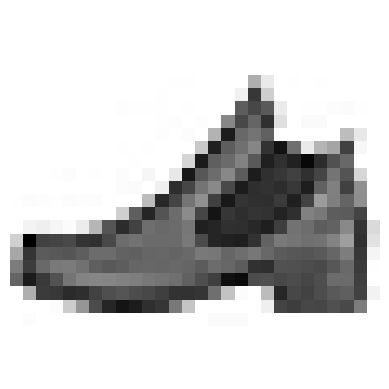

In [4]:
import matplotlib.pyplot as plt

def plot_image(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
# X is a pandas DataFrame, convert to numpy array first
X_train_full = X_train_full.to_numpy()
y_train_full = y_train_full.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

second_item = X_train_full[1]
plot_image(second_item)
plt.show()

In [5]:
y_train_full[1]

9

0 T-shirt/top,1 Trouser, 2 Pullover, 3 Dress, 4 Coat, 5 Sandal, 6 Shirt, 7 Sneaker, 8 Bag, 9 Ankle boot

# Self regularizing SELU network
Let's try a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

tf.random.set_seed(42)
model = Sequential()
model.add(Flatten(input_shape=[784]))
for layer in range(100):
    model.add(Dense(100, activation="selu",
                    kernel_initializer="lecun_normal"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=SGD(learning_rate=0.001),
              metrics=["accuracy"])

2024-02-04 20:47:16.240961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 20:47:16.241058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 20:47:16.373321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [7]:
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_val, y_val = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_val, X_test = X_train / 255., X_val / 255., X_test / 255.

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [9]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_val_scaled = (X_val - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [10]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_val_scaled, y_val))

Epoch 1/5


I0000 00:00:1707079660.565374      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 [==============================] - 48s 19ms/step - loss: 1.1817 - accuracy: 0.5419 - val_loss: 0.9360 - val_accuracy: 0.6608
Epoch 2/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.7745 - accuracy: 0.7136 - val_loss: 0.7392 - val_accuracy: 0.7362
Epoch 3/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.6587 - accuracy: 0.7593 - val_loss: 0.7289 - val_accuracy: 0.7468
Epoch 4/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.5860 - accuracy: 0.7855 - val_loss: 0.5717 - val_accuracy: 0.7880
Epoch 5/5
1719/1719 [==============================] - 32s 19ms/step - loss: 0.5452 - accuracy: 0.8032 - val_loss: 0.5376 - val_accuracy: 0.8106


In [11]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.5256 - accuracy: 0.8091


[0.5256236791610718, 0.8090999722480774]

The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [12]:
tf.random.set_seed(42)

model = Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[784]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [13]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_val_scaled, y_val))

Epoch 1/5
1719/1719 [==============================] - 47s 19ms/step - loss: 2.0145 - accuracy: 0.1893 - val_loss: 1.5857 - val_accuracy: 0.3102
Epoch 2/5
1719/1719 [==============================] - 33s 19ms/step - loss: 1.4342 - accuracy: 0.3879 - val_loss: 1.0510 - val_accuracy: 0.5810
Epoch 3/5
1719/1719 [==============================] - 33s 19ms/step - loss: 1.0888 - accuracy: 0.5498 - val_loss: 1.0324 - val_accuracy: 0.5614
Epoch 4/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.8854 - accuracy: 0.6440 - val_loss: 0.8427 - val_accuracy: 0.6662
Epoch 5/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.8290 - accuracy: 0.6656 - val_loss: 0.7827 - val_accuracy: 0.6736


In [14]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.7792 - accuracy: 0.6769


[0.7791754603385925, 0.6769000291824341]

Not great at all, we suffered from the vanishing/exploding gradients problem. 

# Batch Normalization

In [15]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [16]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Flatten(input_shape=[784]),
    BatchNormalization(),
    Dense(300, activation="relu", kernel_initializer="he_normal"),
    BatchNormalization(),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    BatchNormalization(),
    Dense(10, activation="softmax")
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [18]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [19]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
1719/1719 [==============================] - 9s 4ms/step - loss: 0.5546 - accuracy: 0.8053 - val_loss: 0.4191 - val_accuracy: 0.8516
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4097 - accuracy: 0.8535 - val_loss: 0.3753 - val_accuracy: 0.8672
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3724 - accuracy: 0.8660 - val_loss: 0.3635 - val_accuracy: 0.8714
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3449 - accuracy: 0.8763 - val_loss: 0.3452 - val_accuracy: 0.8764
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3216 - accuracy: 0.8840 - val_loss: 0.3415 - val_accuracy: 0.8756


In [20]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3260 - accuracy: 0.8793


[0.3259752094745636, 0.8792999982833862]

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a BatchNormalization layer does not need to have bias terms, since the BatchNormalization layer has some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [21]:
from tensorflow.keras.layers import Activation

model = Sequential([
    Flatten(input_shape=[784]),
    Dense(300, kernel_initializer="he_normal", use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Dense(100, kernel_initializer="he_normal", use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Dense(10, activation="softmax")
])

In [22]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6139 - accuracy: 0.7935 - val_loss: 0.4568 - val_accuracy: 0.8426
Epoch 2/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4354 - accuracy: 0.8471 - val_loss: 0.3997 - val_accuracy: 0.8596
Epoch 3/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3899 - accuracy: 0.8628 - val_loss: 0.3821 - val_accuracy: 0.8626
Epoch 4/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3578 - accuracy: 0.8732 - val_loss: 0.3682 - val_accuracy: 0.8678
Epoch 5/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3352 - accuracy: 0.8809 - val_loss: 0.3488 - val_accuracy: 0.8732


In [23]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3354 - accuracy: 0.8785


[0.33535057306289673, 0.8784999847412109]

## Gradient clipping

In [24]:
optimizer = SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, 
              metrics="accuracy")
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
1719/1719 [==============================] - 9s 4ms/step - loss: 0.3152 - accuracy: 0.8879 - val_loss: 0.3600 - val_accuracy: 0.8692
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3013 - accuracy: 0.8927 - val_loss: 0.3290 - val_accuracy: 0.8826
Epoch 3/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2869 - accuracy: 0.8983 - val_loss: 0.3322 - val_accuracy: 0.8784
Epoch 4/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2726 - accuracy: 0.9024 - val_loss: 0.3397 - val_accuracy: 0.8800
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2604 - accuracy: 0.9069 - val_loss: 0.3196 - val_accuracy: 0.8856


In [25]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3102 - accuracy: 0.8876


[0.31020745635032654, 0.8876000046730042]

# Faster Optimizers
Below is a little function to generate models with different optimizers.

In [26]:
def build_model(seed=42):
    tf.random.set_seed(seed)
    return Sequential([
        Flatten(input_shape=[784]),
        Dense(100, activation="relu", kernel_initializer="he_normal"),
        Dense(100, activation="relu", kernel_initializer="he_normal"),
        Dense(100, activation="relu", kernel_initializer="he_normal"),
        Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_val, y_val))

## Momentum optimizer

In [27]:
optimizer = SGD(learning_rate=0.001, momentum=0.9)
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7002 - accuracy: 0.7581 - val_loss: 0.5160 - val_accuracy: 0.8196
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4708 - accuracy: 0.8339 - val_loss: 0.4839 - val_accuracy: 0.8346
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4250 - accuracy: 0.8494 - val_loss: 0.4455 - val_accuracy: 0.8406
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3950 - accuracy: 0.8592 - val_loss: 0.4251 - val_accuracy: 0.8512
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3750 - accuracy: 0.8656 - val_loss: 0.4057 - val_accuracy: 0.8604
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3636 - accuracy: 0.8685 - val_loss: 0.3854 - val_accuracy: 0.8634
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3479 - accuracy: 0.8746 - val_loss: 0.3819 - val_accuracy:

# Nesterov Accelerate Gradient

In [28]:
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7037 - accuracy: 0.7591 - val_loss: 0.5115 - val_accuracy: 0.8198
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4668 - accuracy: 0.8352 - val_loss: 0.4682 - val_accuracy: 0.8388
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4222 - accuracy: 0.8500 - val_loss: 0.4616 - val_accuracy: 0.8362
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3936 - accuracy: 0.8599 - val_loss: 0.4096 - val_accuracy: 0.8576
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3718 - accuracy: 0.8669 - val_loss: 0.3941 - val_accuracy: 0.8658
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3576 - accuracy: 0.8712 - val_loss: 0.3838 - val_accuracy: 0.8634
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3433 - accuracy: 0.8765 - val_loss: 0.3826 - val_accuracy:

## AdaGrad

In [29]:
from tensorflow.keras.optimizers import Adagrad, RMSprop, Adam, Adamax, Nadam, AdamW

optimizer = Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0620 - accuracy: 0.6677 - val_loss: 0.7273 - val_accuracy: 0.7532
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6571 - accuracy: 0.7810 - val_loss: 0.6255 - val_accuracy: 0.7844
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5855 - accuracy: 0.8023 - val_loss: 0.5795 - val_accuracy: 0.8062
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5478 - accuracy: 0.8132 - val_loss: 0.5530 - val_accuracy: 0.8140
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5240 - accuracy: 0.8196 - val_loss: 0.5338 - val_accuracy: 0.8168
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5066 - accuracy: 0.8252 - val_loss: 0.5217 - val_accuracy: 0.8222
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4932 - accuracy: 0.8280 - val_loss: 0.5106 - val_accuracy:

## RMSprop

In [30]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5196 - accuracy: 0.8087 - val_loss: 0.4468 - val_accuracy: 0.8444
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3962 - accuracy: 0.8563 - val_loss: 0.4171 - val_accuracy: 0.8542
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3710 - accuracy: 0.8671 - val_loss: 0.4272 - val_accuracy: 0.8574
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3591 - accuracy: 0.8739 - val_loss: 0.4077 - val_accuracy: 0.8546
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3506 - accuracy: 0.8778 - val_loss: 0.3610 - val_accuracy: 0.8774
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3497 - accuracy: 0.8791 - val_loss: 0.3898 - val_accuracy: 0.8702
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3463 - accuracy: 0.8804 - val_loss: 0.4264 - val_accuracy:

# Adam

In [31]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 0.4940 - accuracy: 0.8206 - val_loss: 0.4168 - val_accuracy: 0.8580
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3776 - accuracy: 0.8612 - val_loss: 0.3606 - val_accuracy: 0.8692
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3424 - accuracy: 0.8742 - val_loss: 0.3618 - val_accuracy: 0.8694
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3158 - accuracy: 0.8818 - val_loss: 0.3475 - val_accuracy: 0.8740
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3032 - accuracy: 0.8875 - val_loss: 0.3411 - val_accuracy: 0.8800
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2884 - accuracy: 0.8920 - val_loss: 0.3276 - val_accuracy: 0.8814
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2758 - accuracy: 0.8963 - val_loss: 0.3390 - val_accuracy:

## Adamax

In [32]:
optimizer = Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5381 - accuracy: 0.8111 - val_loss: 0.4429 - val_accuracy: 0.8440
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4045 - accuracy: 0.8551 - val_loss: 0.4132 - val_accuracy: 0.8556
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3657 - accuracy: 0.8689 - val_loss: 0.3899 - val_accuracy: 0.8590
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3394 - accuracy: 0.8775 - val_loss: 0.3728 - val_accuracy: 0.8644
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3227 - accuracy: 0.8831 - val_loss: 0.3477 - val_accuracy: 0.8746
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3094 - accuracy: 0.8869 - val_loss: 0.3455 - val_accuracy: 0.8746
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2966 - accuracy: 0.8917 - val_loss: 0.3490 - val_accuracy:

## Nadam

In [33]:
optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 8s 3ms/step - loss: 0.4882 - accuracy: 0.8246 - val_loss: 0.3971 - val_accuracy: 0.8596
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3744 - accuracy: 0.8626 - val_loss: 0.3797 - val_accuracy: 0.8664
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3424 - accuracy: 0.8743 - val_loss: 0.4125 - val_accuracy: 0.8496
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3167 - accuracy: 0.8830 - val_loss: 0.3353 - val_accuracy: 0.8754
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3004 - accuracy: 0.8894 - val_loss: 0.3401 - val_accuracy: 0.8802
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2858 - accuracy: 0.8938 - val_loss: 0.3320 - val_accuracy: 0.8802
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2737 - accuracy: 0.8976 - val_loss: 0.3503 - val_accuracy:

## AdamW

In [34]:
optimizer = AdamW(weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5007 - accuracy: 0.8191 - val_loss: 0.3970 - val_accuracy: 0.8624
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3790 - accuracy: 0.8608 - val_loss: 0.3822 - val_accuracy: 0.8636
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3426 - accuracy: 0.8739 - val_loss: 0.3851 - val_accuracy: 0.8566
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3181 - accuracy: 0.8815 - val_loss: 0.3474 - val_accuracy: 0.8732
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3023 - accuracy: 0.8877 - val_loss: 0.3405 - val_accuracy: 0.8748
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2899 - accuracy: 0.8915 - val_loss: 0.3395 - val_accuracy: 0.8772
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2762 - accuracy: 0.8967 - val_loss: 0.3309 - val_accuracy:

## Final comparison between optimizers

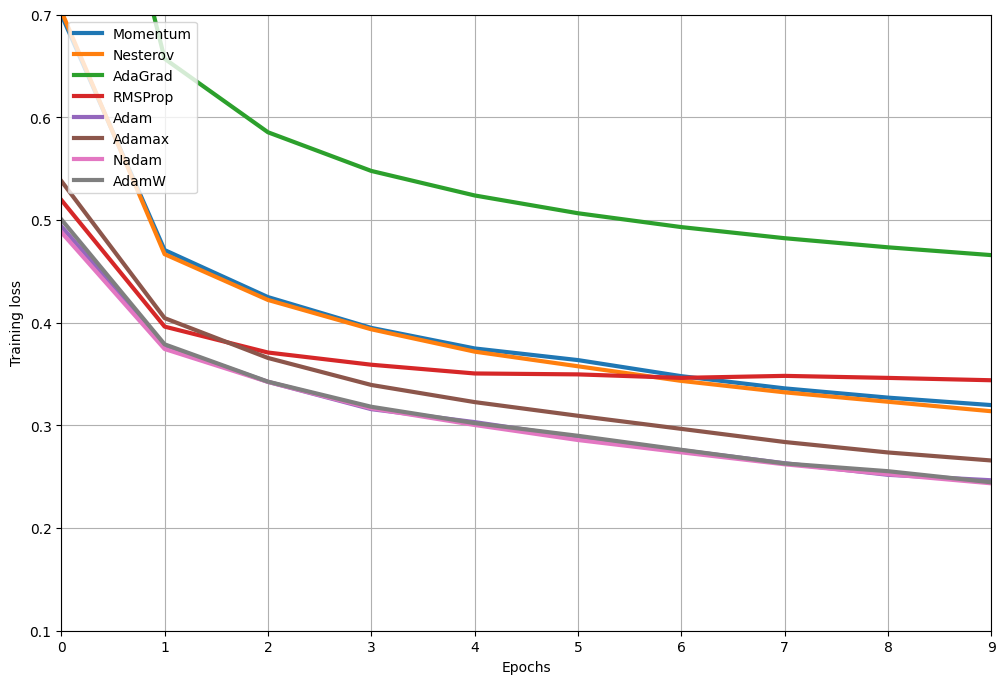

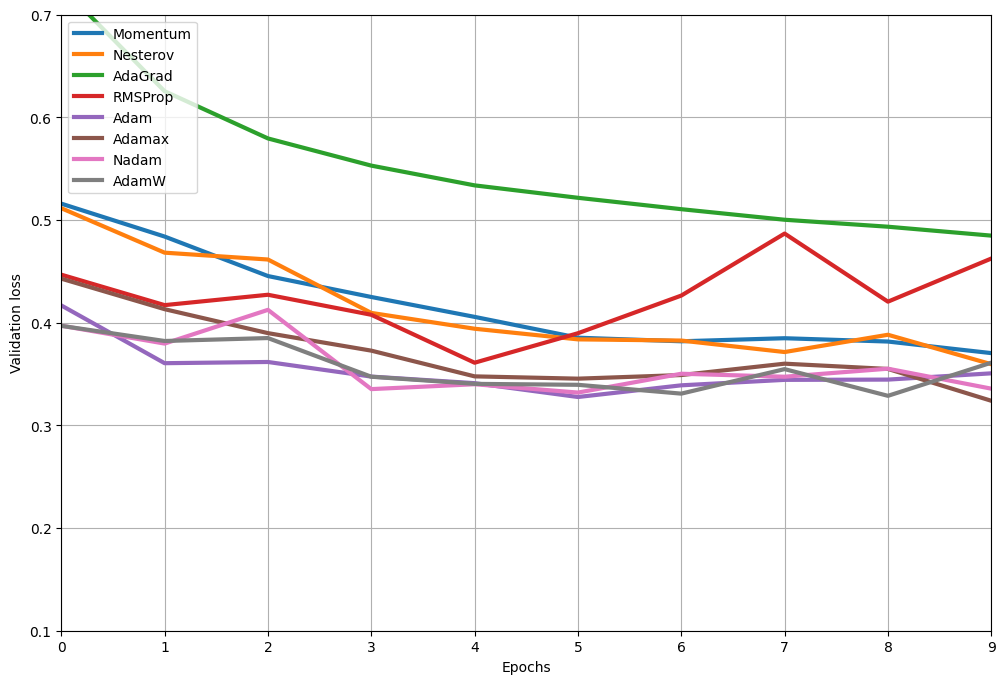

In [35]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

# 1Cycle Learning rate scheduling
The ExponentialLearningRate custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [36]:
from tensorflow.keras.callbacks import Callback

K = tf.keras.backend

class ExponentialLearningRate(Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [37]:
import math

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [38]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [39]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 2s 4ms/step - loss: 1.8104 - accuracy: 0.3967


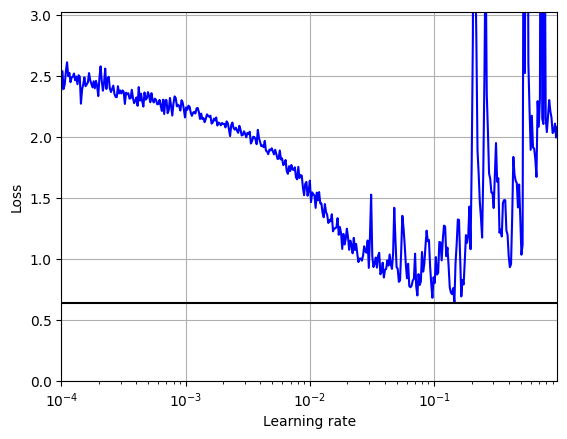

In [40]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 0.08.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the following logic: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [41]:
class OneCycleScheduler(Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

# Putting everything together
Let's build a neural network with 10 hidden layers with Swish activation function and He initialization. Add BN for normalization and Dropout(only after the last hidden layer) and Early Stopping for regularization. Then use AdamW optimizer and 1cycle scheduling.

In [42]:
from tensorflow.keras.layers import Dropout

tf.random.set_seed(42)
model = Sequential()
model.add(Flatten(input_shape=[784]))
for layer in range(10):
    BatchNormalization()
    model.add(Dense(100, activation="swish",
                    kernel_initializer="he_normal"))
model.add(Dropout(rate=0.2))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=AdamW(weight_decay=1e-5, beta_1=0.9, beta_2=0.999),
              metrics=["accuracy"])

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

n_epochs = 30
onecycle = OneCycleScheduler(iterations=math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.08)
checkpoint_cb = ModelCheckpoint("my_fashion_model", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/30
430/430 [==============================] - 10s 13ms/step - loss: 0.5929 - accuracy: 0.7862 - val_loss: 0.4450 - val_accuracy: 0.8416
Epoch 2/30
430/430 [==============================] - 4s 10ms/step - loss: 0.3989 - accuracy: 0.8549 - val_loss: 0.3755 - val_accuracy: 0.8654
Epoch 3/30
430/430 [==============================] - 4s 10ms/step - loss: 0.3588 - accuracy: 0.8704 - val_loss: 0.3720 - val_accuracy: 0.8642
Epoch 4/30
430/430 [==============================] - 4s 10ms/step - loss: 0.3347 - accuracy: 0.8776 - val_loss: 0.3467 - val_accuracy: 0.8778
Epoch 5/30
430/430 [==============================] - 4s 10ms/step - loss: 0.3110 - accuracy: 0.8848 - val_loss: 0.3463 - val_accuracy: 0.8786
Epoch 6/30
430/430 [==============================] - 2s 6ms/step - loss: 0.2992 - accuracy: 0.8897 - val_loss: 0.3507 - val_accuracy: 0.8722
Epoch 7/30
430/430 [==============================] - 5s 12ms/step - loss: 0.2827 - accuracy: 0.8957 - val_loss: 0.3271 - val_accuracy: 0.8868

In [44]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3237 - accuracy: 0.8938


[0.3237271010875702, 0.8938000202178955]

# Results

OneCycle max_lr = 0.1, Adam Optimizer, no Early Stopping: \
89.67% test accuracy

OneCycle max_lr = 0.08, AdamW Optimizer (weight_decay=1e-5), Early Stopping: \
89.23% test accuracy

Not excellent but not bad for a simple DNN